In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
def delayer(input_beam:complex, input_power:float, length:float=1, wavelength:float=3) -> complex:
    """------------------------------------------------------------------------
    De-phase the input beam by heating the fiber with an electrical current.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `power` : Input power in Watts
    - `length` : Fiber length in milimeters
    - `wavelength` : Wavelength in microns
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    # TODO

    return input_beam * np.exp(1j*input_power*np.pi)

def mach_zehnder(beam:complex, power:float) -> complex:
    """------------------------------------------------------------------------
    Partially or totally cancel the light of a beam by
    splitting it in two part, dephasing one path and recombining them.
    
    Parameters
    ----------
    - `input_beam` : Input beam complex amplitude
    - `input_power` : Input power in Watts for the dephasing.
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam + delayer(beam, power)

def random_phase_pertubation(beam:complex, rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random phase pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `rms` : Root mean square of the phase pertubation in radians
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * np.exp(1j * np.random.normal(scale=rms)) 

def random_amplitude_pertubation(beam:complex, rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random amplitude pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `rms` : Root mean square of the relative amplitude pertubation
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * np.random.normal(scale=rms)

def random_phase_and_amplitude_pertubation(beam:complex, phase_rms:float, amplitude_rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random phase and amplitude pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `phase_rms` : Root mean square of the phase pertubation in radians
    - `amplitude_rms` : Root mean square of the relative amplitude pertubation
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * random_phase_pertubation(1, phase_rms) * random_amplitude_pertubation(1, amplitude_rms)

def dot(M,x):
    """------------------------------------------------------------------------
    Compute the dot product of a matrix and a vector.

    Parameters
    ----------
    - `M` : Matrix (2D array)
    - `x` : Vector (1D array)

    Returns
    -------
    - Resulting vector (1D array)
    ------------------------------------------------------------------------"""

    M = np.array(M)
    x = np.array(x)
    y = np.zeros((M.shape[0],*x.shape[1:]), dtype=complex)

    for row in range(M.shape[0]):
        for col in range(M.shape[1]):
            y[row] += M[row][col] * x[col]

    return y

def nuller(beams:list[complex]) -> tuple[complex, list[complex]]:
    """------------------------------------------------------------------------
    Simulate a 4 input beam nuller.
    
    Parameters
    ----------
    - `beams` : List of input beams complex amplitudes
    
    Returns
    -------
    - Bright channel complex amplitude
    - List of dark channels complex amplitudes
    ------------------------------------------------------------------------"""

    N = 1/np.sqrt(4) * np.array([
        [1,  1,  1,  1],
        [1,  1, -1, -1],
        [1, -1,  1, -1],
        [1, -1, -1,  1]
    ])
    
    outputs = dot(N, beams)

    return outputs[0], outputs[1:]

def split_and_mix(beams:list[complex]) -> list[complex]:
    """------------------------------------------------------------------------
    Simulate a 3 input beam split and mix.
    
    Parameters
    ----------
    - `beams` : List of input beams complex amplitudes 
    
    Returns
    -------
    - List of output beams complex amplitudes
        --------------------------------------------------------------------"""
    
    phi = np.pi/2
    S = 1/np.sqrt(4) * np.array([
        [1               , np.exp(1j*phi)  , 0             ],
        [-np.exp(-1j*phi), 1               , 0             ],
        [1               , 0               , np.exp(1j*phi)],
        [-np.exp(-1j*phi), 0               , 1             ],
        [0               , 1               , np.exp(1j*phi)],
        [0               , -np.exp(-1j*phi), 1             ]
    ])

    return dot(S, beams)

<div align=center>

---

# Kernel Nulling V0

</div>

In [3]:
class KernelNullerV0:
    def __init__(
            self,
            input_delay:list[float],
            bright_delay: float,
            null_delay:list[float],
            dark_delay:list[float],
            phase_rms:float=0.1,
            amplitude_rms:float=0.01
        ):
        """--------------------------------------------------------------------
        Create a 4 telescope Kernel-Nuller (version 0)
        
        Parameters
        ----------
        - `input_delay` : Input phase corrective power (list of 4 floats)
        - `null_delay` : Nuller phase corrective power (list of 3 floats)
        - `dark_delay` : Split and mix phase corrective power (list of 6 floats)
        - `phase_rms` : Root mean square of the phase pertubation in radians
        - `amplitude_rms` : Root mean square of the relative amplitude pertubation
        --------------------------------------------------------------------"""

        assert len(input_delay) == 4, "input_delay must be a list of 4 floats"
        assert len(null_delay) == 3, "null_delay must be a list of 3 floats"
        assert len(dark_delay) == 6, "dark_delay must be a list of 6 floats"

        self.input_delay = np.array(input_delay)
        self.bright_delay = bright_delay
        self.null_delay = np.array(null_delay)
        self.dark_delay = np.array(dark_delay)

        self.phase_rms = phase_rms
        self.amplitude_rms = amplitude_rms

        self.input_phase_aberrations = np.array([np.exp(1j * np.random.normal(scale=phase_rms)) for _ in range(4)])
        self.bright_phase_aberation = np.exp(1j * np.random.normal(scale=phase_rms))
        self.null_phase_aberations = np.array([np.exp(1j * np.random.normal(scale=phase_rms)) for _ in range(3)])
        self.dark_phase_aberations = np.array([np.exp(1j * np.random.normal(scale=phase_rms)) for _ in range(6)])

        self.input_amplitude_aberrations = 1 + np.array([np.random.normal(scale=amplitude_rms) for _ in range(4)])
        self.bright_amplitude_aberation = 1 + np.random.normal(scale=amplitude_rms)
        self.null_amplitude_aberations = 1 + np.array([np.random.normal(scale=amplitude_rms) for _ in range(3)])
        self.dark_amplitude_aberations = 1 + np.array([np.random.normal(scale=amplitude_rms) for _ in range(6)])

    def __call__(self, input:list[complex]) -> tuple[complex, list[complex]]:
        """--------------------------------------------------------------------
        Simulate a 4 telescope Kernel-Nuller propagation
        
        Parameters
        ----------
        - `beams` : List of input beams complex amplitudes (ideal)
        
        Returns
        -------
        - Bright channel complex amplitude
        - List of dark channels complex amplitudes
        --------------------------------------------------------------------"""

        perturbed_input = input * self.input_phase_aberrations * self.input_amplitude_aberrations
        corrected_input = delayer(perturbed_input, self.input_delay)

        ideal_bright, ideal_null_channels = nuller(corrected_input)
        perturbed_bright = ideal_bright * self.bright_phase_aberation * self.bright_amplitude_aberation
        perturbed_nulls = ideal_null_channels * self.null_phase_aberations * self.null_amplitude_aberations
        corrected_bright = delayer(perturbed_bright, self.bright_delay)
        corrected_nulls = delayer(perturbed_nulls, self.null_delay)

        ideal_darks = split_and_mix(corrected_nulls)
        perturbed_darks = ideal_darks * self.dark_phase_aberations * self.dark_amplitude_aberations
        corrected_darks = delayer(perturbed_darks, self.dark_delay)
        
        return corrected_bright, corrected_darks, {
            "input": corrected_input,
            "null": corrected_nulls
        }
    
    @property
    def parameters(self):
        return np.array(
            list(self.input_delay)
            + [self.bright_delay]
            + list(self.null_delay)
            + list(self.dark_delay)
        )
    
    def set_parameters(self, parameters:list[float]):
        self.input_delay = np.array(parameters[:4])
        self.bright_delay = parameters[4]
        self.null_delay = np.array(parameters[5:8])
        self.dark_delay = np.array(parameters[8:])

In [4]:
kn0 = KernelNullerV0([0,0,0,0], 0, [0,0,0], [0,0,0,0,0,0], 0.1)

ideal_beams = np.array([
    1e10 + np.exp(1j * 0.10),
    1e10 + np.exp(1j * -0.12),
    1e10 + np.exp(1j * 0.05),
    1e10 + np.exp(1j * -0.01),
])

<div align=center>

---

# GUI

</div>

In [5]:
max_power = 1
step = 1e-20

input_delay1_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 1')
input_delay2_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 2')
input_delay3_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 3')
input_delay4_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 4')

bright_delay_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Bright')

null_delay1_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Null 1')
null_delay2_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Null 2')
null_delay3_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Null 3')

dark_delay1_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 1')
dark_delay2_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 2')
dark_delay3_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 3')
dark_delay4_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 4')
dark_delay5_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 5')
dark_delay6_slider = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 6')

bright, darks, intermediate = kn0(ideal_beams)

def beam_state(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi i)"   

Inputs = [widgets.Label(value=f" ") for _ in range(4)]
NullerDarks = [widgets.Label(value=f" ") for _ in range(3)]
Bright = widgets.Label(value=f" ")
Darks = [widgets.Label(value=f" ") for _ in range(6)]

def update_gui(*args):

    kn0.input_delay = np.array([input_delay1_slider.value, input_delay2_slider.value, input_delay3_slider.value, input_delay4_slider.value])
    kn0.bright_delay = bright_delay_slider.value
    kn0.null_delay = np.array([null_delay1_slider.value, null_delay2_slider.value, null_delay3_slider.value])
    kn0.dark_delay = np.array([dark_delay1_slider.value, dark_delay2_slider.value, dark_delay3_slider.value, dark_delay4_slider.value, dark_delay5_slider.value, dark_delay6_slider.value])

    bright, darks, inter = kn0(ideal_beams)

    Bright.value = f"Bright: {beam_state(bright)}"
    for i, dark in enumerate(darks):
        Darks[i].value = f"Dark {i}: {beam_state(dark)}"
    for i, v in enumerate(inter['input']):
        Inputs[i].value = f"Input {i}: {beam_state(v)}"
    for i, v in enumerate(inter['null']):
        NullerDarks[i].value = f"Nuller {i}: {beam_state(v)}"

    return bright, darks


for widget in [input_delay1_slider, input_delay2_slider, input_delay3_slider, input_delay4_slider, bright_delay_slider, null_delay1_slider, null_delay2_slider, null_delay3_slider, dark_delay1_slider, dark_delay2_slider, dark_delay3_slider, dark_delay4_slider, dark_delay5_slider, dark_delay6_slider]:
    widget.observe(update_gui, 'value')

empty = widgets.Label()

widgets.VBox([
    widgets.Label("Input phase corrective powers:"),
    widgets.HBox([input_delay1_slider, input_delay2_slider, input_delay3_slider, input_delay4_slider]),
    *[widgets.HBox([x]) for x in Inputs],
    widgets.Label("Nuller phase corrective powers:"),
    widgets.HBox([bright_delay_slider, null_delay1_slider, null_delay2_slider, null_delay3_slider]),
    *[widgets.HBox([x]) for x in [Bright] + NullerDarks],
    widgets.Label("Split & Mix phase corrective powers:"),
    widgets.HBox([dark_delay1_slider, dark_delay2_slider, dark_delay3_slider]),
    widgets.HBox([dark_delay4_slider, dark_delay5_slider, dark_delay6_slider]),
    *[widgets.HBox([x]) for x in [Bright] + Darks],
])

<div align=center>

---

# Convergeance

</div>

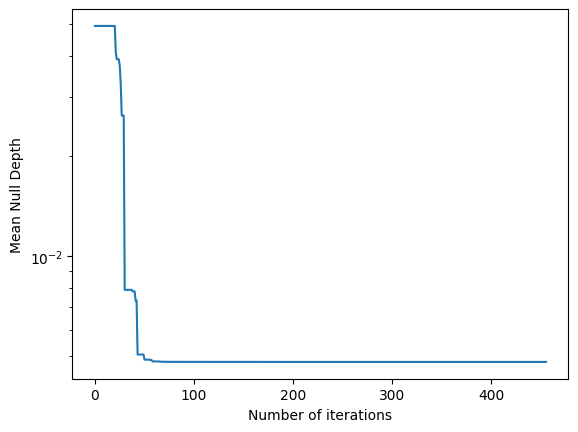

In [6]:
import time

def optimize(kn0, beam):

    delta = 1
    null_depth_evol = []

    while delta > step:
        delta /= 1.5

        # print("\n==========\n")

        for i in range(len(kn0.parameters[:4])):

            # print("---")
            
            # print(f"Initial parameters : {kn0.parameters}")
            # print(f"Delta : {delta:.2e}")

            old_bright, old_darks, _ = kn0(beam)

            parameters = kn0.parameters
            change = np.zeros(len(parameters))
            change[i] = delta
            
            kn0.set_parameters(parameters + change)
            pos_bright, pos_darks, _ = kn0(beam)

            kn0.set_parameters(parameters - change)
            neg_bright, neg_darks, _ = kn0(beam)

            old_null_mean = np.sum(np.abs(old_darks)) / len(old_darks) / np.abs(old_bright)
            pos_null_mean = np.sum(np.abs(pos_darks)) / len(pos_darks) / np.abs(pos_bright)
            neg_null_mean = np.sum(np.abs(neg_darks)) / len(neg_darks) / np.abs(neg_bright)

            # print("\n", old_null_mean, pos_null_mean, neg_null_mean)

            null_depth_evol.append(old_null_mean)

            if pos_null_mean < old_null_mean and pos_null_mean < neg_null_mean:
                # print(f"+ {old_null_mean:.2e} -> {pos_null_mean:.2e} ")
                kn0.set_parameters(parameters + change)
            elif neg_null_mean < old_null_mean and neg_null_mean < pos_null_mean:
                # print(f"- {old_null_mean:.2e} -> {neg_null_mean:.2e} ")
                kn0.set_parameters(parameters - change)
            else:
                # print(f"= {old_null_mean:.2e} < {pos_null_mean:.2e}, {neg_null_mean:.2e}")
                kn0.set_parameters(parameters)

            # print(f"Final parameters : {kn0.parameters}")

    return null_depth_evol

null_depth_evol = optimize(kn0, ideal_beams)

plt.plot(null_depth_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null Depth")
plt.yscale("log")
plt.show()

<div align=center>

---

# Distribution

</div>

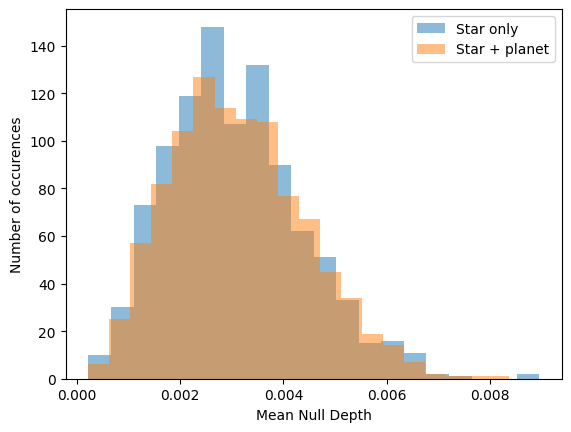

In [7]:
N = 1000
bins = 20

input_delay = [0,0,0,0]
bright_delay = 0
null_delay = [0,0,0]
dark_delay = [0,0,0,0,0,0]
phase_rms = 0.1 # radians
amplitude_rms = 0.01 # ratio

ideal_beams = np.array([
    1e10 + 0j,
    1e10 + 0j,
    1e10 + 0j,
    1e10 + 0j,
])

null_depth = []
for _ in range(N):
    kn0 = KernelNullerV0(input_delay, bright_delay, null_delay, dark_delay, phase_rms)
    null_depth.append(optimize(kn0, ideal_beams)[-1])

plt.hist(null_depth, bins=bins, alpha=0.5, label="Star only")
plt.xlabel("Mean Null Depth")
plt.ylabel("Number of occurences")

ideal_beams = np.array([
    1e10 + np.exp(1j * 0.2* 0.01),
    1e10 + np.exp(1j * 0.2* -0.012),
    1e10 + np.exp(1j * 0.2* 0.005),
    1e10 + np.exp(1j * 0.2* -0.001),
])

null_depth = []
for _ in range(N):
    kn0 = KernelNullerV0(input_delay, bright_delay, null_delay, dark_delay, phase_rms, amplitude_rms)
    null_depth.append(optimize(kn0, ideal_beams)[-1])

plt.hist(null_depth, bins=bins, alpha=0.5, label="Star + planet")
plt.legend()
plt.show()